# Calibrate Cameras

In [40]:
class Args:
    dataset_path = "../../resources/images/uncalibrated/calibration_dataset.npz"
    marker_length = 5.625
    square_length = 7.5

args = Args()

In [41]:
import numpy as np
import cv2
from cv2 import aruco
from matplotlib import pyplot as plt

from models.dataset.DatasetHelper import save_coefficients

In [42]:

def calibrate_charuco(images: list):
    '''Apply camera calibration using aruco.
    The dimensions are in cm.
    '''
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50) 
    board = aruco.CharucoBoard_create(7, 5, args.square_length, args.marker_length, aruco_dict)
    arucoParams = aruco.DetectorParameters_create()

    image_id = -1
    image_ids, corners_list, id_list = [], [], []
    # Find the ArUco markers inside each image
    for image in images:
        image_id = image_id + 1

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners, ids, _ = aruco.detectMarkers(
            img_gray, 
            aruco_dict, 
            parameters=arucoParams
        )

        if ids is None: # did not detect any corners
            continue

        resp, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=img_gray,
            board=board
        )

        if charuco_corners is None:
            continue
        
        # If a Charuco board was found, let's collect image/corner points
        # Requiring at least 20 squares
        if resp > 10:
            # Add these corners and ids to our calibration arrays
            corners_list.append(charuco_corners)
            id_list.append(charuco_ids)
            image_ids.append(image_id)

        # print markers on image
        aruco.drawDetectedMarkers(image, corners, ids)
        aruco.drawDetectedCornersCharuco(image, charuco_corners, charuco_ids)


    # Actual calibration
    _, cameraMatrix, _, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_list, 
        charucoIds=id_list, 
        board=board, 
        imageSize=img_gray.shape, 
        cameraMatrix=None, 
        distCoeffs=None)

    print(cameraMatrix)

    return rvecs, tvecs, image_ids

In [43]:
def get_homogeneous(rvecs, tvecs):
    hom = np.identity(4)
    rmat, _ = cv2.Rodrigues(np.reshape(rvecs, -1))
    hom[0:3, 0:3] = rmat
    hom[0:3, 3] = np.squeeze(tvecs[0])
    return hom

In [44]:
def inverse_affine(mat):
    rot = mat[0:3, 0:3]
    trans = mat[0:3, 3]
    rot_inv = np.linalg.inv(rot)
    trans_inv = -rot_inv @ trans
    inv_mat = np.identity(4)
    inv_mat[0:3, 0:3] = rot_inv
    inv_mat[0:3, 3] = trans_inv
    return inv_mat

### Calculate & save intr. & extr. matrix

[[1.36937642e+03 0.00000000e+00 9.30213954e+02]
 [0.00000000e+00 1.37133200e+03 5.42192044e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[2.74373118e+03 0.00000000e+00 9.46713918e+02]
 [0.00000000e+00 2.73588758e+03 5.82900437e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Mean Transformation Matrix:
[[ 9.85694168e-01  1.62607245e-02 -1.54242802e-01  3.25331442e+01]
 [-1.66598873e-02  9.97242500e-01 -2.26440930e-03 -4.13724632e+01]
 [ 1.54579174e-01  4.40083588e-03  9.87294301e-01  3.37779913e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Standard Deviation of Transformation Matrizes:
[ 0.40798734  0.43069049  0.45885949 32.65662036]


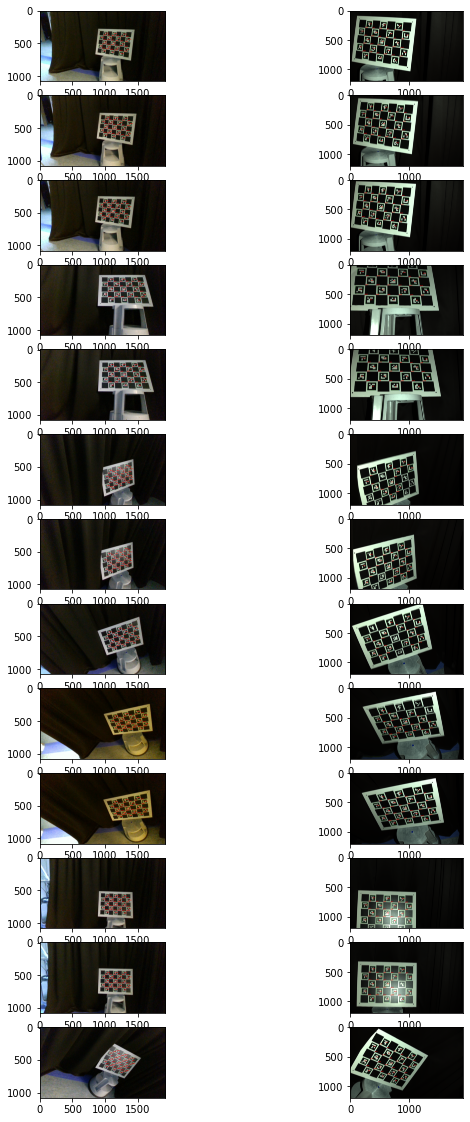

In [45]:
from matplotlib import pyplot as plt
from models.dataset.DatasetHelper import openImageDataset

# load images
realsenseColor, _, zividColor, _ = openImageDataset(args.dataset_path)

# Calibrate 
rvecs_rs, tvecs_rs, image_ids_rs = calibrate_charuco(realsenseColor)
rvecs_ziv, tvecs_ziv, image_ids_ziv = calibrate_charuco(zividColor)

# Calculate both homogenous transformation matrixes
Ts_rs = []
Ts_ziv = []
ids = [(i, j)  for i, x in enumerate(image_ids_rs) for j, y in enumerate(image_ids_ziv) if x == y]

for idx, (id_rs, id_ziv) in enumerate(ids):
    Ts_rs.append(get_homogeneous(rvecs_rs[id_rs], tvecs_rs[id_rs]))
    Ts_ziv.append(get_homogeneous(rvecs_ziv[id_ziv], tvecs_ziv[id_ziv]))

Ts_ziv_to_rs = []
for T_rs, T_ziv in zip(Ts_rs, Ts_ziv):
    ex = inverse_affine(T_rs) @ T_ziv
    Ts_ziv_to_rs.append(ex)
    #print(ex)

T_ziv_to_rs = np.mean(Ts_ziv_to_rs, axis=0)
Ts_ziv_to_rs = Ts_ziv_to_rs[0]

print("Mean Transformation Matrix:")
print(T_ziv_to_rs)

print("Standard Deviation of Transformation Matrizes:")
print(np.std(Ts_ziv_to_rs, axis=0))

# plot images
f, axarr = plt.subplots(len(ids), 2, figsize=(10, 20))
for idx, img_id in enumerate(list(set(image_ids_rs) & set(image_ids_ziv))):
    axarr[idx][0].imshow(realsenseColor[img_id])
    axarr[idx][1].imshow(zividColor[img_id])

# Save transformation matrix into a file
# save_coefficients(T_ziv_to_rs, '../../resources/calibrations/calibration.yml')

0.075 m
4x4 aruco a 1/8 bzw 6/8 * 0.075 

# Transform Images
[https://towardsdatascience.com/how-to-transform-a-2d-image-into-a-3d-space-5fc2306e3d36](https://towardsdatascience.com/how-to-transform-a-2d-image-into-a-3d-space-5fc2306e3d36)

In [46]:
def transform(image):
    (_, _, r_z), _ = cv2.Rodrigues(T_ziv_to_rs[0:3, 0:3])
    theta_rz = np.deg2rad(r_z)

    # get the height and the width of the image
    h, w = image.shape[:2]
    # compute its diagonal
    diag = (h ** 2 + w ** 2) ** 0.5
    # compute the focal length
    f = diag
    if np.sin(theta_rz) != 0:
        f /= 2 * np.sin(theta_rz)
        
    # set the image from cartesian to projective dimension
    H_M = np.array([[1, 0, -w / 2],
                    [0, 1, -h / 2],
                    [0, 0,      1],
                    [0, 0,      1]])
    # set the image projective to carrtesian dimension
    Hp_M = np.array([[f, 0, w / 2, 0],
                     [0, f, h / 2, 0],
                     [0, 0,     1, 0]])
    """
            We will define our matrices here in next parts
                                                            """
    Identity = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])
    
    # compute the full transform matrix
    M = Identity @ T_ziv_to_rs
    M = np.dot(Hp_M, np.dot(M, H_M))
    # apply the transformation
    image = cv2.warpPerspective(image, M, (w, h))
    return image

In [47]:
rot_vector, _ = cv2.Rodrigues(T_ziv_to_rs[0:3, 0:3])
trans_vector = T_ziv_to_rs[0:3, 3]
print(rot_vector, trans_vector)

for ziv in zividColor:
    updated_image = transform(ziv)
plt.imshow(updated_image)

[[ 0.00334548]
 [-0.15525962]
 [-0.01655011]] [ 32.53314421 -41.37246318  33.77799131]


/tmp/ipykernel_28973/2518085911.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Hp_M = np.array([[f, 0, w / 2, 0],


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'warpPerspective'
> Overload resolution failed:
>  - M data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'M'


### Transform using o3d [http://www.open3d.org/docs/release/tutorial/geometry/transformation.html](http://www.open3d.org/docs/release/tutorial/geometry/transformation.html)

In [ ]:

dst = cv2.undistort(
    original, mtx_rs, dist, None, mtx_rs
)
cv2.imwrite('../../resources/images/calibrated/undist_rs.png', dst)